In [10]:
# =========================
# Cell 1: Environment Setup
# =========================

import os
import random
import numpy as np
import torch

# ---- 1. 设备检查 ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---- 2. 固定随机种子（保证可复现）----
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

# ---- 3. Kaggle 数据集根目录 ----
BASE = "/kaggle/input/recodai-luc-scientific-image-forgery-detection"

# ---- 4. 检查数据集结构 ----
print("\nDataset root contains:")
for p in os.listdir(BASE):
    print(" -", p)

# ---- 5. 基础路径（后续统一使用）----
TRAIN_IMG_FORGED = os.path.join(BASE, "train_images", "forged")
TRAIN_IMG_AUTH   = os.path.join(BASE, "train_images", "authentic")
TRAIN_MASK_DIR   = os.path.join(BASE, "train_masks")

SUPP_IMG_DIR     = os.path.join(BASE, "supplemental_images")
SUPP_MASK_DIR    = os.path.join(BASE, "supplemental_masks")

TEST_IMG_DIR     = os.path.join(BASE, "test_images")

print("\nKey paths check:")
print("TRAIN_IMG_FORGED exists:", os.path.exists(TRAIN_IMG_FORGED))
print("TRAIN_IMG_AUTH exists  :", os.path.exists(TRAIN_IMG_AUTH))
print("TRAIN_MASK_DIR exists  :", os.path.exists(TRAIN_MASK_DIR))
print("TEST_IMG_DIR exists    :", os.path.exists(TEST_IMG_DIR))


Using device: cuda

Dataset root contains:
 - sample_submission.csv
 - train_images
 - supplemental_masks
 - train_masks
 - supplemental_images
 - test_images

Key paths check:
TRAIN_IMG_FORGED exists: True
TRAIN_IMG_AUTH exists  : True
TRAIN_MASK_DIR exists  : True
TEST_IMG_DIR exists    : True


In [11]:
# =========================
# Cell 2: Build Samples
# =========================

import os
import random

samples = []

# ---- 1. forged（有 mask）----
for fn in sorted(os.listdir(TRAIN_IMG_FORGED)):
    if not fn.lower().endswith((".png", ".jpg", ".jpeg", ".tif", ".tiff")):
        continue
    case_id = os.path.splitext(fn)[0]
    mask_path = os.path.join(TRAIN_MASK_DIR, f"{case_id}.npy")

    # 兜底：有些图片可能没有对应 mask（理论上不该发生）
    if not os.path.exists(mask_path):
        continue

    samples.append({
        "case_id": case_id,
        "img": os.path.join(TRAIN_IMG_FORGED, fn),
        "mask": mask_path,
        "label": "forged"
    })

# ---- 2. authentic（无 mask）----
for fn in sorted(os.listdir(TRAIN_IMG_AUTH)):
    if not fn.lower().endswith((".png", ".jpg", ".jpeg", ".tif", ".tiff")):
        continue
    case_id = os.path.splitext(fn)[0]

    samples.append({
        "case_id": case_id,
        "img": os.path.join(TRAIN_IMG_AUTH, fn),
        "mask": None,                 # 关键：authentic 没有 mask
        "label": "authentic"
    })

# ---- 3. supplemental（作为 forged 使用，有 mask）----
for fn in sorted(os.listdir(SUPP_IMG_DIR)):
    if not fn.lower().endswith((".png", ".jpg", ".jpeg", ".tif", ".tiff")):
        continue
    case_id = os.path.splitext(fn)[0]
    mask_path = os.path.join(SUPP_MASK_DIR, f"{case_id}.npy")

    if not os.path.exists(mask_path):
        continue

    samples.append({
        "case_id": case_id,
        "img": os.path.join(SUPP_IMG_DIR, fn),
        "mask": mask_path,
        "label": "forged"
    })

# ---- 4. 打乱并划分 train / val ----
random.seed(42)
random.shuffle(samples)

split = int(0.8 * len(samples))
train_samples = samples[:split]
val_samples   = samples[split:]

# ---- 5. 统计与 sanity check ----
def count_labels(ss):
    return {
        "forged": sum(s["label"] == "forged" for s in ss),
        "authentic": sum(s["label"] == "authentic" for s in ss),
        "total": len(ss)
    }

print("Total samples:", count_labels(samples))
print("Train samples:", count_labels(train_samples))
print("Val samples  :", count_labels(val_samples))

print("\nFirst 3 samples:")
for s in samples[:3]:
    print(s)


Total samples: {'forged': 2799, 'authentic': 2377, 'total': 5176}
Train samples: {'forged': 2228, 'authentic': 1912, 'total': 4140}
Val samples  : {'forged': 571, 'authentic': 465, 'total': 1036}

First 3 samples:
{'case_id': '8109', 'img': '/kaggle/input/recodai-luc-scientific-image-forgery-detection/train_images/authentic/8109.png', 'mask': None, 'label': 'authentic'}
{'case_id': '35467', 'img': '/kaggle/input/recodai-luc-scientific-image-forgery-detection/train_images/forged/35467.png', 'mask': '/kaggle/input/recodai-luc-scientific-image-forgery-detection/train_masks/35467.npy', 'label': 'forged'}
{'case_id': '4957', 'img': '/kaggle/input/recodai-luc-scientific-image-forgery-detection/train_images/authentic/4957.png', 'mask': None, 'label': 'authentic'}


In [12]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from PIL import Image


class ForgeryDataset(Dataset):
    def __init__(self, samples, img_size=256):
        self.samples = samples
        self.img_size = img_size

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]

        # =========================
        # 1. Image
        # =========================
        img_pil = Image.open(s["img"]).convert("RGB")
        orig_w, orig_h = img_pil.size

        img = img_pil.resize((self.img_size, self.img_size))
        img = torch.from_numpy(
            np.array(img, dtype=np.float32) / 255.0
        ).permute(2, 0, 1)  # [3,H,W]

        # =========================
        # 2. Mask
        # =========================
        mask = None

        if s["mask"] is not None:
            try:
                raw = np.load(s["mask"])
                raw = np.array(raw)

                # ---- 多通道统一处理 ----
                if raw.ndim == 3:
                    # (H,W,C)
                    if raw.shape[-1] <= 10:
                        raw = raw[..., 0]
                    # (C,H,W)
                    elif raw.shape[0] <= 10:
                        raw = raw[0]

                # ---- 一维 mask ----
                if raw.ndim == 1:
                    if raw.size == orig_h * orig_w:
                        raw = raw.reshape(orig_h, orig_w)
                    else:
                        raise ValueError("mask size mismatch")

                # ---- 必须是二维 ----
                if raw.ndim != 2:
                    raise ValueError("mask dim invalid")

                # ---- 尺寸必须匹配 image ----
                if raw.shape != (orig_h, orig_w):
                    raise ValueError("mask/image shape mismatch")

                raw = (raw > 0).astype(np.uint8)
                mask = torch.from_numpy(raw).float()  # [H,W]

            except Exception:
                mask = None

        # ---- 所有失败情况：mask = 全 0 ----
        if mask is None:
            mask = torch.zeros((orig_h, orig_w), dtype=torch.float32)

        # ---- resize（关键：严格构造 4D）----
        mask = mask.unsqueeze(0).unsqueeze(0)   # [1,1,H,W]
        mask = F.interpolate(
            mask,
            size=(self.img_size, self.img_size),
            mode="nearest"
        )
        mask = mask.squeeze(0)                  # [1,H,W]

        return img, mask


In [13]:
# =========================
# Cell 4: DataLoader
# =========================

from torch.utils.data import DataLoader

# ---- 1. 构建 Dataset ----
train_dataset = ForgeryDataset(train_samples, img_size=256)
val_dataset   = ForgeryDataset(val_samples, img_size=256)

# ---- 2. DataLoader 参数 ----
BATCH_SIZE = 4      # DeepLabV3(+)-ResNet101 显存占用大，先保守
NUM_WORKERS = 2     # Kaggle 稳定值（0~2 都行）

# ---- 3. DataLoader ----
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=False
)

# ---- 4. quick sanity check ----
imgs, masks = next(iter(train_loader))
print("Batch image shape:", imgs.shape)   # [B,3,256,256]
print("Batch mask shape :", masks.shape)  # [B,1,256,256]
print("Mask batch max/min:", masks.max().item(), masks.min().item())


Batch image shape: torch.Size([4, 3, 256, 256])
Batch mask shape : torch.Size([4, 1, 256, 256])
Mask batch max/min: 1.0 0.0


In [15]:
# =========================
# Cell 5: Model Definition
# =========================

import torch.nn as nn
from torchvision.models.segmentation import deeplabv3_resnet101

# ---- 1. 加载 DeepLabV3-ResNet101 ----
model = deeplabv3_resnet101(weights="DEFAULT")

# ---- 2. 修改 classifier：21 → 1 ----
# DeepLabV3 的 classifier 结构是：
# Sequential(
#   (0): Conv2d(2048, 256, 3, padding=1)
#   (1): BatchNorm2d(256)
#   (2): ReLU
#   (3): Conv2d(256, num_classes, 1)
# )
model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)

# ---- 3. 移动到 GPU ----
model = model.to(device)

# ---- 4. quick forward sanity check ----
model.eval()
with torch.no_grad():
    imgs, masks = next(iter(train_loader))
    imgs = imgs.to(device)
    out = model(imgs)["out"]

print("Model output shape:", out.shape)  # [B,1,256,256]


Model output shape: torch.Size([4, 1, 256, 256])


In [16]:
# =========================
# Cell 6: Loss & Optimizer
# =========================

import torch
import torch.nn as nn

# ---- Dice Loss（小区域友好）----
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps

    def forward(self, logits, targets):
        """
        logits : [B,1,H,W]
        targets: [B,1,H,W]
        """
        probs = torch.sigmoid(logits)
        targets = targets.float()

        inter = (probs * targets).sum(dim=(1, 2, 3))
        union = probs.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3))

        dice = (2 * inter + self.eps) / (union + self.eps)
        return 1 - dice.mean()


dice_loss = DiceLoss()

# ---- BCE（处理极度不平衡）----
pos_weight = torch.tensor([5.0], device=device)
bce_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# ---- 组合 loss ----
def loss_fn(logits, targets):
    return 0.7 * dice_loss(logits, targets) + 0.3 * bce_loss(logits, targets)

# ---- Optimizer ----
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-5
)

print("Loss & Optimizer ready.")


Loss & Optimizer ready.


In [17]:
# =========================
# Cell 7: Train & Validate
# =========================

import torch
from tqdm import tqdm

# ---- 验证函数：Dice ----
def evaluate(model, loader, thresh=0.3):
    model.eval()
    dices = []

    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            logits = model(imgs)["out"]
            probs = torch.sigmoid(logits)
            preds = (probs > thresh).float()

            inter = (preds * masks).sum(dim=(1,2,3))
            union = preds.sum(dim=(1,2,3)) + masks.sum(dim=(1,2,3))
            dice = (2 * inter + 1e-6) / (union + 1e-6)

            dices.append(dice.mean().item())

    return sum(dices) / len(dices)


# ---- 训练参数 ----
EPOCHS = 10
THRESH = 0.3   # copy-move 常用阈值

# ---- 训练循环 ----
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{EPOCHS}]")

    for imgs, masks in pbar:
        imgs = imgs.to(device)
        masks = masks.to(device)

        logits = model(imgs)["out"]
        loss = loss_fn(logits, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    avg_loss = total_loss / len(train_loader)
    val_dice = evaluate(model, val_loader, thresh=THRESH)

    print(
        f"[Epoch {epoch+1}/{EPOCHS}] "
        f"Train Loss: {avg_loss:.4f} | Val Dice: {val_dice:.4f}"
    )


Epoch [1/10]: 100%|██████████| 1035/1035 [11:35<00:00,  1.49it/s, loss=0.7621]


[Epoch 1/10] Train Loss: 0.7429 | Val Dice: 0.1742


Epoch [2/10]: 100%|██████████| 1035/1035 [11:33<00:00,  1.49it/s, loss=0.7046]


[Epoch 2/10] Train Loss: 0.6898 | Val Dice: 0.2367


Epoch [3/10]: 100%|██████████| 1035/1035 [11:32<00:00,  1.50it/s, loss=0.5564]


[Epoch 3/10] Train Loss: 0.6670 | Val Dice: 0.2308


Epoch [4/10]: 100%|██████████| 1035/1035 [11:31<00:00,  1.50it/s, loss=0.6391]


[Epoch 4/10] Train Loss: 0.6510 | Val Dice: 0.2834


Epoch [5/10]: 100%|██████████| 1035/1035 [11:31<00:00,  1.50it/s, loss=0.5875]


[Epoch 5/10] Train Loss: 0.6345 | Val Dice: 0.2192


Epoch [6/10]: 100%|██████████| 1035/1035 [11:30<00:00,  1.50it/s, loss=0.6541]


[Epoch 6/10] Train Loss: 0.6181 | Val Dice: 0.2684


Epoch [7/10]: 100%|██████████| 1035/1035 [11:31<00:00,  1.50it/s, loss=0.6848]


[Epoch 7/10] Train Loss: 0.6034 | Val Dice: 0.2421


Epoch [8/10]: 100%|██████████| 1035/1035 [11:30<00:00,  1.50it/s, loss=0.6269]


[Epoch 8/10] Train Loss: 0.5859 | Val Dice: 0.2684


Epoch [9/10]: 100%|██████████| 1035/1035 [11:29<00:00,  1.50it/s, loss=0.5489]


[Epoch 9/10] Train Loss: 0.5708 | Val Dice: 0.2132


Epoch [10/10]: 100%|██████████| 1035/1035 [11:29<00:00,  1.50it/s, loss=0.4893]


[Epoch 10/10] Train Loss: 0.5609 | Val Dice: 0.2192


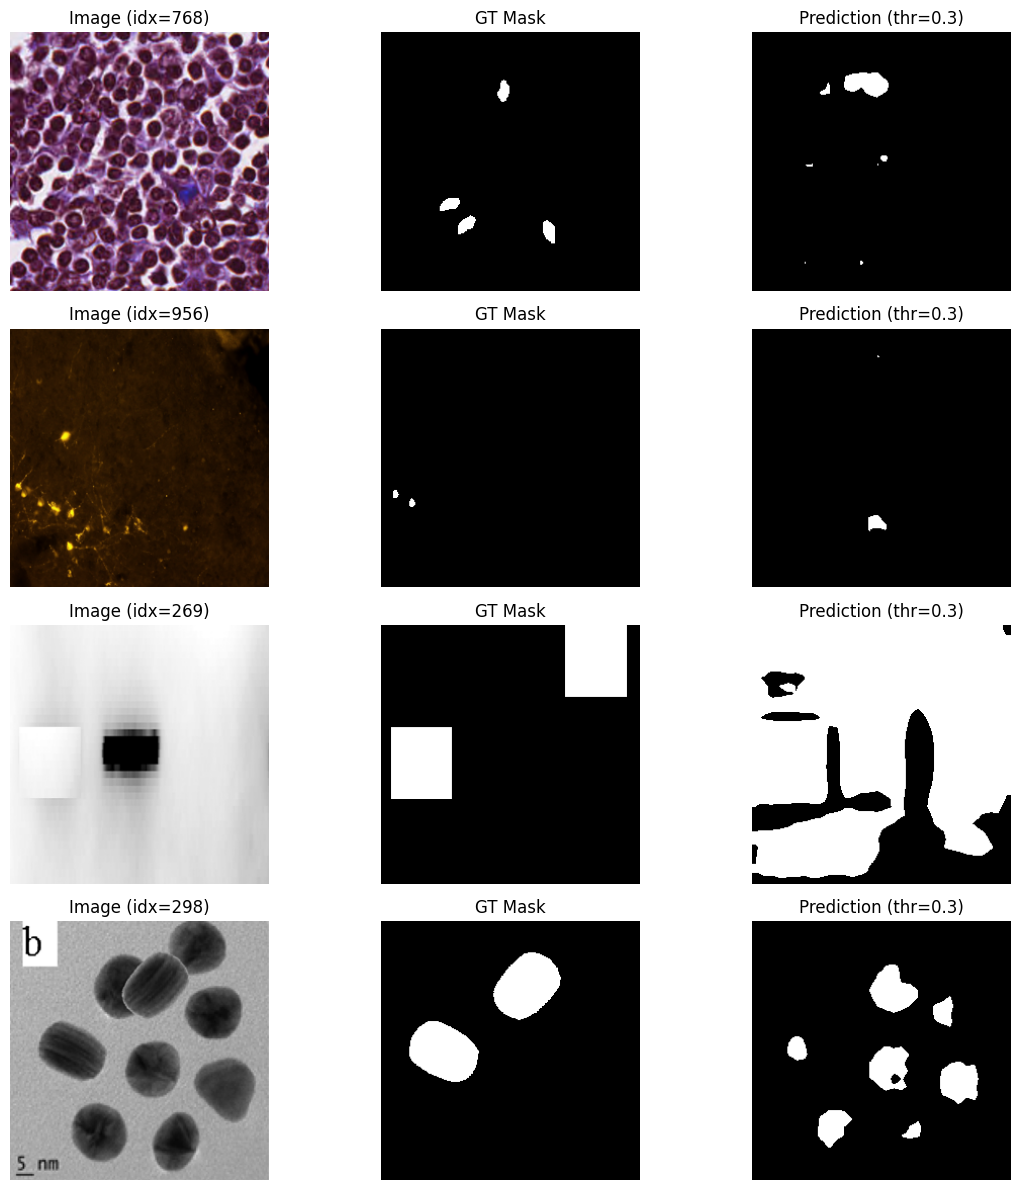

In [19]:
# =========================
# Cell 9: Visualization (4 Samples)
# =========================

import matplotlib.pyplot as plt
import random
import torch

def visualize_4_samples(model, dataset, thresh=0.3, prefer_forged=True):
    """
    model: trained model
    dataset: train_dataset or val_dataset
    thresh: binarization threshold
    prefer_forged: True -> 优先选 forged 样本
    """
    model.eval()

    # ---- 选 4 个样本 ----
    if prefer_forged:
        indices = [i for i, s in enumerate(dataset.samples) if s["label"] == "forged"]
        indices = random.sample(indices, 4)
    else:
        indices = random.sample(range(len(dataset)), 4)

    plt.figure(figsize=(12, 12))

    for row, idx in enumerate(indices):
        img, gt_mask = dataset[idx]

        img_t = img.unsqueeze(0).to(device)
        gt_mask_np = gt_mask[0].cpu().numpy()

        with torch.no_grad():
            logits = model(img_t)["out"]
            prob = torch.sigmoid(logits)[0, 0].cpu().numpy()
            pred_mask = (prob > thresh).astype("uint8")

        # ---- Image ----
        plt.subplot(4, 3, row * 3 + 1)
        plt.imshow(img.permute(1, 2, 0))
        plt.title(f"Image (idx={idx})")
        plt.axis("off")

        # ---- GT Mask ----
        plt.subplot(4, 3, row * 3 + 2)
        plt.imshow(gt_mask_np, cmap="gray")
        plt.title("GT Mask")
        plt.axis("off")

        # ---- Prediction ----
        plt.subplot(4, 3, row * 3 + 3)
        plt.imshow(pred_mask, cmap="gray")
        plt.title(f"Prediction (thr={thresh})")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# ---- 在 val 集上可视化 4 个 forged 样本 ----
visualize_4_samples(
    model=model,
    dataset=val_dataset,
    thresh=0.3,
    prefer_forged=True
)
